In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim

from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = '/content/drive/MyDrive/Data/2.건설기계부문_data/test_data'
files = os.listdir(folder_path)

df_list = []  # 데이터프레임을 저장할 리스트

for file in files:
    file_path = os.path.join(folder_path, file)

    # 파일 이름의 첫 7글자로 데이터프레임 이름 생성
    df_name = file[:7] + '_df'

    # CSV 파일을 불러와서 데이터프레임으로 저장
    df = pd.read_csv(file_path)

    # label 컬럼을 파일 이름의 첫 3글자로 채움
    df['label'] = file[-5:-4]

    # 데이터프레임을 리스트에 추가
    df_list.append(df)

# 모든 데이터프레임을 하나로 합침
test_df = pd.concat(df_list, ignore_index=True)

In [4]:
# 테스트 데이터 불러오기
test_data = test_df.copy()

# 결과 저장을 위한 빈 데이터프레임
normalized_test_data = pd.DataFrame()

# 레이블별로 그룹화하여 시간 정규화
unique_labels = test_data['label'].unique()

for label in unique_labels:
    label_data = test_data[test_data['label'] == label].copy()

    # **시간 정규화**
    time_min = label_data['Time[s]'].min()
    time_max = label_data['Time[s]'].max()
    label_data['Time[s]'] = (label_data['Time[s]'] - time_min) / (time_max - time_min)

    # 정규화된 데이터를 결과 데이터프레임에 추가
    normalized_test_data = pd.concat([normalized_test_data, label_data], ignore_index=True)

In [5]:
def normalize_data(data_df):
    """
    Normalize the data using standard scaling (z-score normalization).
    """
    # Sensor and Signal columns
    signal_columns = ['Signal A', 'Signal B', 'Signal C']
    sensor_columns = ['Sensor A', 'Sensor B', 'Sensor C', 'Sensor D']

    # Standard scaling for Signal columns (individual scaling)
    for column in signal_columns:
        mean_value = data_df[column].mean()
        std_value = data_df[column].std()
        data_df[column] = (data_df[column] - mean_value) / std_value

    # Standard scaling for Sensor columns (individual scaling)
    for column in sensor_columns:
        mean_value = data_df[column].mean()
        std_value = data_df[column].std()
        data_df[column] = (data_df[column] - mean_value) / std_value

    return data_df

# 데이터프레임 불러오기
test_normalized_test_data = normalize_data(normalized_test_data)


In [6]:
def make_test_data(data_df, window_size=3000, stride=5):
    test_sequences = []
    test_labels = []

    # Ensure label is in float format and sort by 'Time[s]'
    data_df['label'] = data_df['label'].astype(float)
    grouped_data = data_df.sort_values(['Time[s]']).groupby('label')

    # Sensor and Signal columns
    sensor_columns = ['Sensor A', 'Sensor B', 'Sensor C', 'Sensor D']
    signal_columns = ['Signal A', 'Signal B', 'Signal C']

    # Combine sensor and signal columns
    feature_columns = sensor_columns + signal_columns

    for label, group in grouped_data:
        label_data = label / 902.0  # Scale label

        # Extract sequences from each group
        for i in range(0, len(group) - window_size + 1, stride):
            window_data = group.iloc[i:i + window_size].copy()

            # Select sensor and signal columns
            sequence = window_data[feature_columns].to_numpy()

            # Append to test data
            test_sequences.append(sequence)
            test_labels.append(label_data)

    return np.array(test_sequences), np.array(test_labels)


In [7]:
# 사용 예시
window_size = 1000
stride = 10

# Test 데이터를 생성합니다.
test_sequences, test_labels = make_test_data(normalized_test_data, window_size=window_size, stride=stride)

In [8]:
# 텐서로 변환
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

# DataLoader 생성
batch_size = 512
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Test Loader created with {len(test_loader)} batches.")

Test Loader created with 15 batches.


In [9]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, output_size, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1000, d_model))  # max sequence length is 500
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        seq_len = x.size(1)
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        x += self.positional_encoding[:, :seq_len, :]
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x)  # (seq_len, batch_size, d_model)
        x = x.mean(dim=0)  # Global average pooling across sequence length
        x = self.fc(x)  # (batch_size, output_size)
        return x

In [10]:
# Initialize model parameters
input_size = test_sequences.shape[-1]
d_model = 128
nhead = 8
num_encoder_layers = 3
dim_feedforward = 256
output_size = 1
dropout = 0.2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-11-45019c84a88f>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you st

Loaded best model from /content/drive/MyDrive/제출/건설기계/best_transformer_model.pth


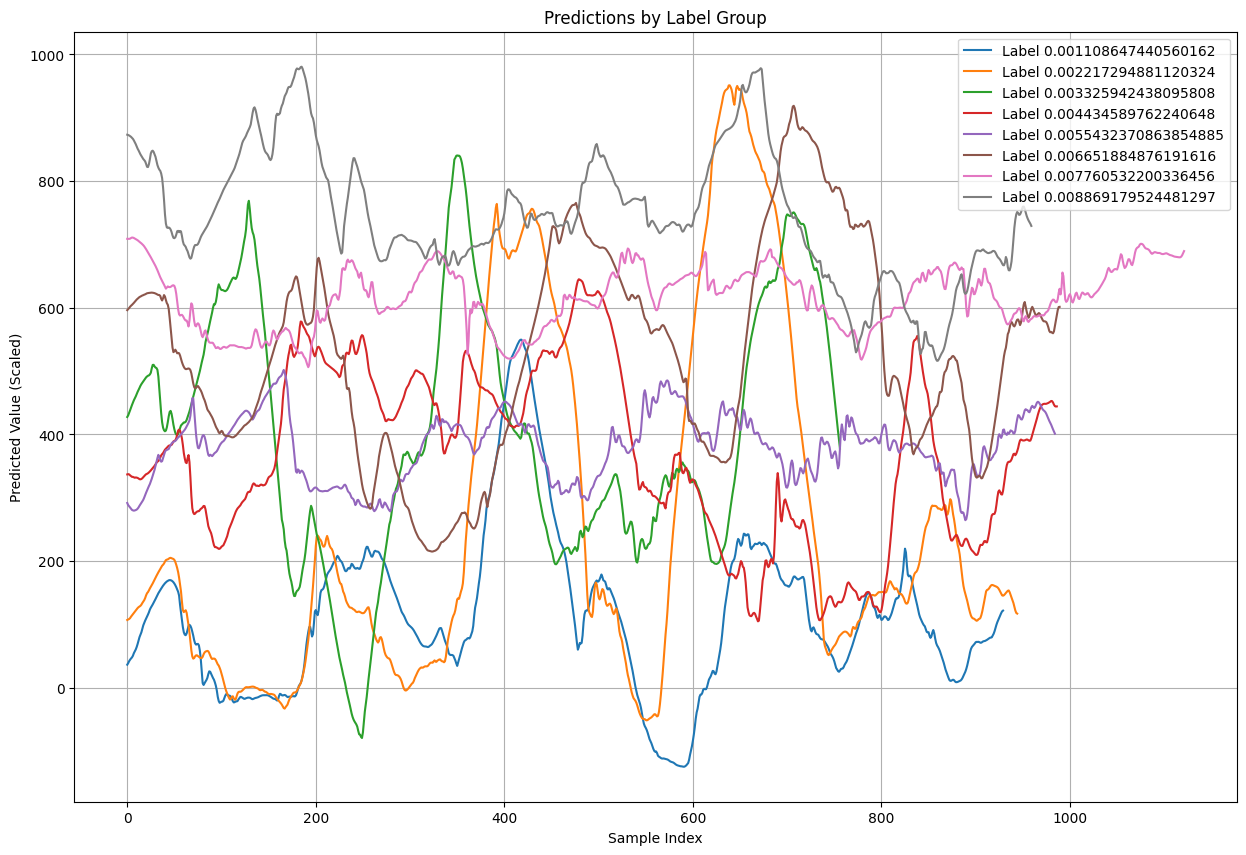

Label 0.001108647440560162:
  Number of Predictions: 930
  Mean Prediction: 114.5152
  Std Dev of Predictions: 127.4174
Label 0.002217294881120324:
  Number of Predictions: 945
  Mean Prediction: 259.5924
  Std Dev of Predictions: 275.4531
Label 0.003325942438095808:
  Number of Predictions: 757
  Mean Prediction: 401.8528
  Std Dev of Predictions: 203.3470
Label 0.004434589762240648:
  Number of Predictions: 987
  Mean Prediction: 367.0290
  Std Dev of Predictions: 135.6307
Label 0.0055432370863854885:
  Number of Predictions: 985
  Mean Prediction: 379.5763
  Std Dev of Predictions: 51.3866
Label 0.006651884876191616:
  Number of Predictions: 990
  Mean Prediction: 526.7149
  Std Dev of Predictions: 164.7379
Label 0.007760532200336456:
  Number of Predictions: 1122
  Mean Prediction: 616.3560
  Std Dev of Predictions: 48.0087
Label 0.008869179524481297:
  Number of Predictions: 960
  Mean Prediction: 744.8245
  Std Dev of Predictions: 100.9162


In [11]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = TransformerRegressor(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    output_size=output_size,
    dropout=dropout
).to(device)

best_model_path ='/content/drive/MyDrive/제출/건설기계/best_transformer_model.pth'

# 저장된 모델 로드
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")

# 모델을 평가 모드로 전환
model.eval()
predictions_by_label = defaultdict(list)  # 레이블별 예측값 저장

# 테스트 데이터에 대한 예측 수행
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        # 모델 예측
        outputs = model(inputs)
        # 예측값을 레이블별로 그룹화
        for pred, label in zip(outputs.squeeze(1).cpu().numpy(), labels.cpu().numpy()):
            predictions_by_label[label].append(pred * 902.0)  # 필요 시 스케일링 값을 수정

# 레이블별 예측값 정리 및 시각화
plt.figure(figsize=(15, 10))
for label, preds in predictions_by_label.items():
    plt.plot(preds, label=f"Label {label}")

plt.title("Predictions by Label Group")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Value (Scaled)")
plt.legend()
plt.grid()
plt.show()

# 레이블별 예측값 요약 출력
for label, preds in predictions_by_label.items():
    print(f"Label {label}:")
    print(f"  Number of Predictions: {len(preds)}")
    print(f"  Mean Prediction: {np.mean(preds):.4f}")
    print(f"  Std Dev of Predictions: {np.std(preds):.4f}")


In [15]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = TransformerRegressor(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    output_size=output_size,
    dropout=dropout
).to(device)

best_model_path ='/content/drive/MyDrive/제출/건설기계/best_transformer_model.pth'

# 저장된 모델 로드
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")

# 모델을 평가 모드로 전환
model.eval()
predictions_by_label = defaultdict(list)  # 레이블별 예측값 저장

# 테스트 데이터에 대한 예측 수행
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        # 모델 예측
        outputs = model(inputs)

        # 예측값을 레이블별로 그룹화
        for pred, label in zip(outputs.squeeze(1).cpu().numpy(), labels.cpu().numpy()):
            predictions_by_label[label].append(pred * 902.0)  # 필요 시 스케일링 값을 수정

# 레이블별 평균 예측값 계산
label_means = {}
for label, preds in predictions_by_label.items():
    label_means[label] = np.mean(preds)

# 레이블별 평균값 출력
print("Label-wise Mean Predictions:")
for label, mean_pred in label_means.items():
    print(f"Label {label}: {mean_pred:.4f}")

<ipython-input-15-ed6ca97b474b>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loaded best model from /content/drive/MyDrive/제출/건설기계/best_transformer_model.pth
Label-wise Mean Predictions:
Label 0.001108647440560162: 114.5152
Label 0.002217294881120324: 259.5924
Label 0.003325942438095808: 401.8528
Label 0.004434589762240648: 367.0290
Label 0.0055432370863854885: 379.5763
Label 0.006651884876191616: 526.7149
Label 0.007760532200336456: 616.3560
Label 0.008869179524481297: 744.8245
